In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader 
from torch.utils.data import random_split

import torch_geometric.transforms as T

from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda")
cpu_device = torch.device("cpu")

/data3/home/karmpatel/miniconda3/envs/torch310/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Dataset

In [2]:
cur_dataset = TUDataset(root='dataset', name = 'PROTEINS')
# cur_dataset = TUDataset(root="dataset/loaded/", 
#                                name="IMDB-BINARY")
cur_dataset

PROTEINS(1113)

In [3]:
cur_dataset.get_summary()

TUDataset (#graphs=1113):
+------------+----------+----------+
|            |   #nodes |   #edges |
|------------+----------+----------|
| mean       |     39.1 |    145.6 |
| std        |     45.8 |    169.3 |
| min        |      4   |     10   |
| quantile25 |     15   |     56   |
| median     |     26   |     98   |
| quantile75 |     45   |    174   |
| max        |    620   |   2098   |
+------------+----------+----------+

In [4]:
cur_dataset.raw_file_names

['PROTEINS_A.txt', 'PROTEINS_graph_indicator.txt']

In [5]:
cur_dataset.raw_paths

['dataset/PROTEINS/raw/PROTEINS_A.txt',
 'dataset/PROTEINS/raw/PROTEINS_graph_indicator.txt']

In [6]:
dl = DataLoader(cur_dataset, batch_size=16, shuffle=True)

/data3/home/karmpatel/miniconda3/envs/torch310/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [7]:
db = next(iter(dl))
db

DataBatch(edge_index=[2, 2390], x=[673, 3], y=[16], batch=[673], ptr=[17])

In [8]:
db.x.shape # (num_nodes, feature_dim)

torch.Size([673, 3])

In [9]:
db.batch # indices are nodes and values shows the graph where that node belongs to, it generally sorted by graph
db.batch

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  3,  3,  3,  3,  3,  3, 

In [10]:
db.edge_index # sparse tensor represnetation of adjency list

tensor([[  0,   0,   0,  ..., 672, 672, 672],
        [  1,   7,   8,  ..., 666, 667, 671]])

### Mean pooling GCN Model

In [72]:
class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, gcn_channels = [32, 32, 32, 1], num_classes=2):
        super(GNNStack, self).__init__()
        self.convs = nn.ModuleList()
        self.gcn_channels = [input_dim] + gcn_channels
        for i in range(len(self.gcn_channels)-1):
            self.convs.append(pyg_nn.GCNConv(self.gcn_channels[i], self.gcn_channels[i+1]))
        
        self.sort_pool = pyg_nn.SortAggregation(k=30)
        self.conv5 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=sum(gcn_channels), stride=sum(gcn_channels))
        self.pool = nn.MaxPool1d(2, 2)
        self.conv6 = nn.Conv1d(16, 32, 5, 1)
        self.classifier_1 = nn.Linear(352, 128)
        self.drop_out = nn.Dropout(0.5)
        self.classifier_2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU(inplace=True)

        self.num_layers = len(gcn_channels)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if data.num_node_features == 0:
            x = torch.ones(data.num_nodes, 1)
        
        ops = []
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.tanh(x)
            ops.append(x)
            
        x = torch.cat(x, dim=-1)
        x = self.sort_pool(x, batch)
        x = x.view(x.size(0), 1, x.size(-1))
        x = self.relu(self.conv5(x))
        x = self.pool(x)
        x = self.relu(self.conv6(x))
        x = x.view(x.size(0), -1)
        out = self.relu(self.classifier_1(x))
        out = self.drop_out(out)
        log_probs = F.log_softmax(self.classifier_2(out), dim=-1)

        return out, log_probs

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

In [73]:
gnn_model = GNNStack(input_dim=3, hidden_dim=128, output_dim=64).to(device)

In [74]:
emb, log_probs = gnn_model(db.to(device))
emb.shape, log_probs.shape

TypeError: cat() received an invalid combination of arguments - got (Tensor, dim=int), but expected one of:
 * (tuple of Tensors tensors, int dim, *, Tensor out)
 * (tuple of Tensors tensors, name dim, *, Tensor out)


In [55]:
data_size = len(cur_dataset) 
train_size = int(0.8*data_size)
train_dataset, val_dataset = random_split(cur_dataset, [train_size, data_size-train_size])
len(train_dataset), len(val_dataset)

(890, 223)

In [56]:
B = 512
train_dataloader = DataLoader(train_dataset, batch_size=B, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=B, shuffle=True)

In [57]:
def train_epoch(opt, gnn_model, train_dataloader):
    train_losses = []
    tqdm_obj = tqdm(train_dataloader)
    gnn_model.train()
    for each in tqdm_obj:
        embs, log_probs = gnn_model(each.to(device))
        y_pred = torch.argmax(log_probs, axis=-1)
        loss = gnn_model.loss(log_probs, each.y)
        loss.backward()
        opt.step()
        opt.zero_grad() 
        train_losses.append(loss.detach().to(cpu_device))
        tqdm_obj.set_description_str(f"Train loss: {loss.item()}")
    
    return train_losses, embs, log_probs

In [58]:
def val_epoch(opt, gnn_model, val_dataloader):
    val_losses = []
    with torch.no_grad():
        gnn_model.eval()
        tqdm_obj = tqdm(val_dataloader)
        for each in tqdm_obj:
            embs, log_probs = gnn_model(each.to(device))
            y_pred = torch.argmax(log_probs, axis=-1)
            loss = gnn_model.loss(log_probs, each.y)
            val_losses.append(loss.detach().to(cpu_device))
            tqdm_obj.set_description_str(f"Val loss: {loss.item()}")
    
    return val_losses, embs, log_probs

In [59]:
opt = optim.Adam(gnn_model.parameters(), lr=0.001)
train_losses, _, _ = train_epoch(opt, gnn_model, train_dataloader)

Train loss: 4.161624908447266: 100%|███████████████████████████████████████████████████| 2/2 [00:00<00:00, 31.00it/s]


In [60]:
total_train_losses, total_val_losses = [], []
n_epochs = 500
for epoch in range(n_epochs):
    train_losses, _, _ = train_epoch(opt, gnn_model, train_dataloader)
    total_train_losses.extend(train_losses)
    
    val_losses, _, _ = val_epoch(opt, gnn_model, val_dataloader)
    total_val_losses.extend(val_losses)

Train loss: 0.698165237903595: 100%|███████████████████████████████████████████████████| 2/2 [00:00<00:00, 35.00it/s]


Val loss: 0.6718445420265198: 100%|████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.96it/s]


Train loss: 0.6429218649864197: 100%|██████████████████████████████████████████████████| 2/2 [00:00<00:00, 34.96it/s]


Val loss: 0.6435449123382568: 100%|████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.76it/s]


Train loss: 0.6209420561790466: 100%|██████████████████████████████████████████████████| 2/2 [00:00<00:00, 34.38it/s]


Val loss: 0.6056584715843201: 100%|████████████████████████████████████████████████████| 1/1 [00:00<00:00, 42.01it/s]


Train loss: 0.6194692254066467: 100%|██████████████████████████████████████████████████| 2/2 [00:00<00:00, 35.65it/s]


Val loss: 0.5991121530532837: 100%|████████████████████████████████████████████████████| 1/1 [00:00<00:00, 42.06it/s]


Train loss: 0.6310767531394958: 100%|██████████████████████████████████████████████████| 2/2 [00:00<00:00, 34.85it/s]


Val loss: 0.5977246165275574: 100%|████████████████████████████████████████████████████| 1/1 [00:00<00:00, 42.11it/s]


Train loss: 0.5979897975921631: 100%|██████████████████████████████████████████████████| 2/2 [00:00<00:00, 33.71it/s]


Val loss: 0.5993592143058777: 100%|████████████████████████████████████████████████████| 1/1 [00:00<00:00, 42.19it/s]


Train loss: 0.572823703289032: 100%|███████████████████████████████████████████████████| 2/2 [00:00<00:00, 34.93it/s]


Val loss: 0.5977787971496582: 100%|████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.73it/s]


Val loss: 0.596791684627533: 100%|█████████████████████████████████████████████████████| 1/1 [00:00<00:00, 42.16it/s]


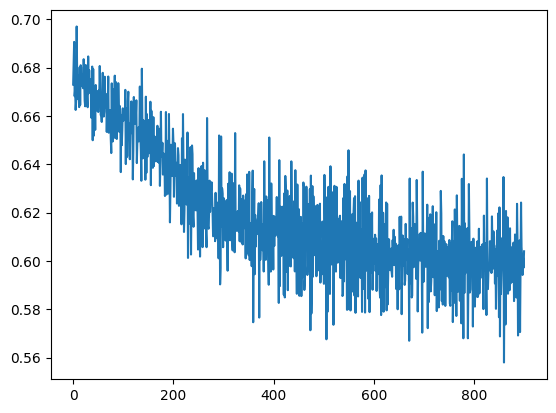

In [63]:
plt.plot(total_train_losses[100:])

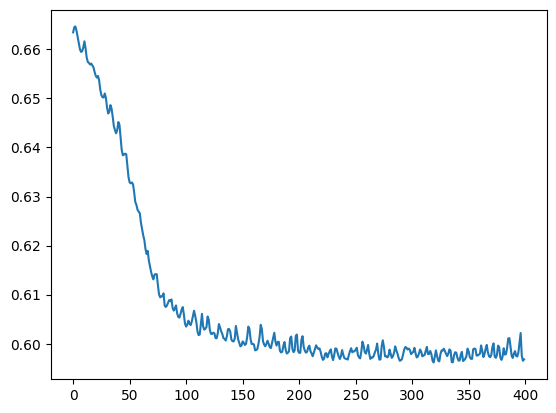

In [65]:
plt.plot(total_val_losses[100:])

In [ ]:
def train(dataset, task, writer):
    if task == 'graph':
        data_size = len(dataset)
        loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=64, shuffle=True)
        test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=64, shuffle=True)
    else:
        test_loader = loader = DataLoader(dataset, batch_size=64, shuffle=True)

    # build model
    model = GNNStack(max(dataset.num_node_features, 1), 32, dataset.num_classes, task=task)
    opt = optim.Adam(model.parameters(), lr=0.01)
    
    # train
    for epoch in range(200):
        total_loss = 0
        model.train()
        for batch in loader:
            #print(batch.train_mask, '----')
            opt.zero_grad()
            embedding, pred = model(batch)
            label = batch.y
            if task == 'node':
                pred = pred[batch.train_mask]
                label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        writer.add_scalar("loss", total_loss, epoch)

        if epoch % 10 == 0:
            test_acc = test(test_loader, model)
            print("Epoch {}. Loss: {:.4f}. Test accuracy: {:.4f}".format(
                epoch, total_loss, test_acc))
            writer.add_scalar("test accuracy", test_acc, epoch)

    return model


In [ ]:
# class GNNStack(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim, gcn_channels = [32, 32, 32, 1]):
#         super(GNNStack, self).__init__()
#         self.convs = nn.ModuleList()
#         self.gcn_channels = [input_dim] + gcn_channels
# #         self.convs.append(self.build_conv_model(input_dim, hidden_dim))
#         self.lns = nn.ModuleList()
#         self.lns.append(nn.LayerNorm(hidden_dim))
#         self.lns.append(nn.LayerNorm(hidden_dim))
#         for i in range(len(self.gcn_channels)-1):
#             self.convs.append(self.build_conv_model(self.gcn_channels[i], ))

#         # post-message-passing
#         self.post_mp = nn.Sequential(
#             nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.25), 
#             nn.Linear(hidden_dim, output_dim))
#         if not (self.task == 'node' or self.task == 'graph'):
#             raise RuntimeError('Unknown task.')

#         self.dropout = 0.25
#         self.num_layers = 3

#     def build_conv_model(self, input_dim, hidden_dim):
#         # refer to pytorch geometric nn module for different implementation of GNNs.
#         if self.task == 'node':
#             return pyg_nn.GCNConv(input_dim, hidden_dim)
#         else:
#             return pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim),
#                                   nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)))

#     def forward(self, data):
#         x, edge_index, batch = data.x, data.edge_index, data.batch
#         if data.num_node_features == 0:
#           x = torch.ones(data.num_nodes, 1)

#         for i in range(self.num_layers):
#             x = self.convs[i](x, edge_index)
#             emb = x
#             x = F.relu(x)
#             x = F.dropout(x, p=self.dropout, training=self.training)
#             if not i == self.num_layers - 1:
#                 x = self.lns[i](x)

#         if self.task == 'graph':
#             x = pyg_nn.global_mean_pool(x, batch)

#         x = self.post_mp(x)

#         return emb, F.log_softmax(x, dim=1)

#     def loss(self, pred, label):
#         return F.nll_loss(pred, label)